In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

# 1. DB 연결
db_uri = "postgresql+psycopg2://xodh3@localhost:5432/economy_db"
engine = create_engine(db_uri)

🦁 야수 4대장 데이터 소환 중... 완료! ✅


/var/folders/px/mxxc21bs63gcw44m35sp_51r0000gn/T/ipykernel_2881/2067094226.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
/var/folders/px/mxxc21bs63gcw44m35sp_51r0000gn/T/ipykernel_2881/2067094226.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.set_index('trade_date').resample('M').last() # 월말 종가 기준
/var/folders/px/mxxc21bs63gcw44m35sp_51r0000gn/T/ipykernel_2881/2067094226.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
/var/folders/px/mxxc21bs63gcw44m35sp_51r0000gn/T/ipykernel_2881/2067094226.py:23: FutureWarning: 'M' is deprecated and will

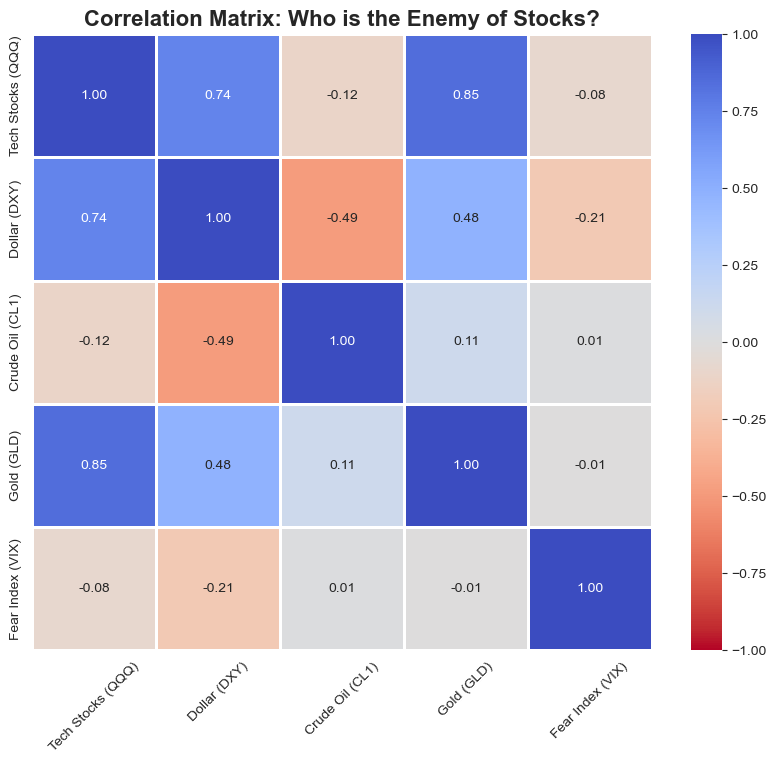

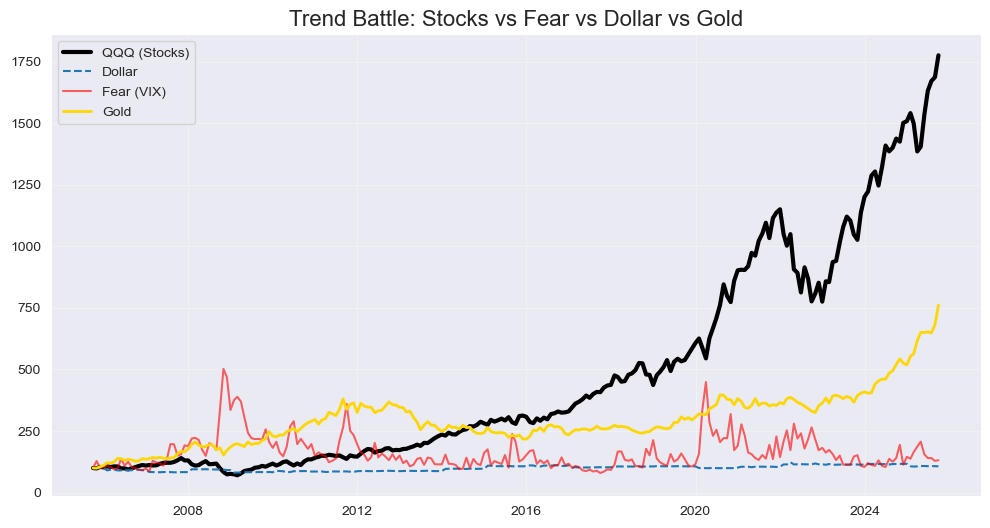

📋 주식(QQQ)과의 상관계수 성적표:
Crude Oil (CL1)     -0.116683
Fear Index (VIX)    -0.084248
Dollar (DXY)         0.740184
Gold (GLD)           0.845600
Tech Stocks (QQQ)    1.000000
Name: Tech Stocks (QQQ), dtype: float64


In [6]:

# 1. DB 연결
db_uri = "postgresql+psycopg2://xodh3@localhost:5432/economy_db"
engine = create_engine(db_uri)

# 2. 데이터 불러오기 함수
def get_data(symbol, name):
    table = "market_price_daily"
    # 심볼별로 데이터가 있는지 확인하고 가져옵니다
    query = f"SELECT trade_date, close_price FROM {table} WHERE symbol = '{symbol}' ORDER BY trade_date ASC"

    conn = engine.raw_connection()
    try:
        df = pd.read_sql(query, conn)
    finally:
        conn.close()

    if df.empty:
        print(f"⚠️ 데이터 없음: {symbol}")
        return pd.DataFrame()

    df = df.rename(columns={'trade_date': 'trade_date', 'close_price': name})
    df['trade_date'] = pd.to_datetime(df['trade_date'], utc=True)
    df = df.set_index('trade_date').resample('M').last() # 월말 종가 기준
    return df

print("🦁 야수 4대장 데이터 소환 중...", end=" ")

# (1) 주식 (주인공)
df_qqq = get_data('QQQ', 'Tech Stocks (QQQ)')

# (2) 별종들 (심볼 확정!)
df_dxy = get_data('DXY', 'Dollar (DXY)')    # 달러 인덱스
df_oil = get_data('CL1', 'Crude Oil (CL1)') # 원유 선물
df_gold = get_data('GLD', 'Gold (GLD)')     # 금 ETF
df_vix = get_data('VIXCLS', 'Fear Index (VIX)') # 공포 지수

print("완료! ✅")

# 3. 데이터 합치기 (교집합)
dfs = [df_qqq, df_dxy, df_oil, df_gold, df_vix]
dfs = [d for d in dfs if not d.empty]
df_market = pd.concat(dfs, axis=1, join='inner')

# 4. 📊 시각화 1: 상관관계 히트맵 (Friend or Foe?)
plt.figure(figsize=(10, 8))
# 상관계수 계산 (-1: 완전 반대, +1: 완전 똑같음)
sns.heatmap(df_market.corr(), annot=True, fmt=".2f", cmap='coolwarm_r', vmin=-1, vmax=1, linewidths=1)
# cmap='coolwarm_r' : 파란색(반대)이 주식엔 안 좋으므로(적), 직관적으로 보이게 색상 반전 등을 고려할 수 있음.
# 여기선 빨강=동행(양의 상관), 파랑=역행(음의 상관)입니다.

plt.title("Correlation Matrix: Who is the Enemy of Stocks?", fontsize=16, fontweight='bold')
plt.xticks(rotation=45)
plt.show()

# 5. 📊 시각화 2: 움직임 비교 (정규화)
# 2023년 1월 1일 = 100으로 통일해서 그래프 그리기
df_norm = df_market / df_market.iloc[0] * 100

plt.figure(figsize=(12, 6))
plt.plot(df_norm.index, df_norm['Tech Stocks (QQQ)'], label='QQQ (Stocks)', color='black', linewidth=3)
plt.plot(df_norm.index, df_norm['Dollar (DXY)'], label='Dollar', linestyle='--')
plt.plot(df_norm.index, df_norm['Fear Index (VIX)'], label='Fear (VIX)', color='red', alpha=0.6)
plt.plot(df_norm.index, df_norm['Gold (GLD)'], label='Gold', color='gold', linewidth=2)

plt.title("Trend Battle: Stocks vs Fear vs Dollar vs Gold", fontsize=16)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 최근 상관계수 확인
print("📋 주식(QQQ)과의 상관계수 성적표:")
print(df_market.corr()['Tech Stocks (QQQ)'].sort_values())

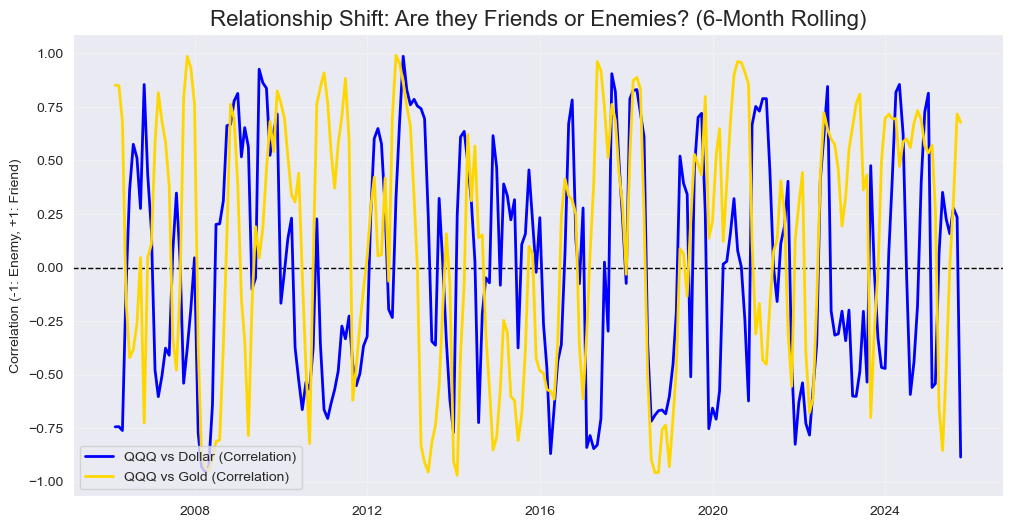

🧐 현재 달러와의 관계 (최근 6개월): -0.88
👉 진단: '역행' 구간입니다. 달러가 오르면 주식은 박살 납니다. (전통적 패턴)


In [7]:
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# 🌊 이동 상관관계 (Rolling Correlation) 분석
# ---------------------------------------------------------
# 목표: "달러와 주식의 관계가 시간에 따라 어떻게 변했나?"

# 1. 윈도우 설정 (6개월 = 약 126 거래일, 여기선 월별 데이터니 6개월)
window_size = 6

# 2. 이동 상관계수 계산
# QQQ와 DXY의 상관관계를 6개월 단위로 계속 다시 계산
rolling_corr_dxy = df_market['Tech Stocks (QQQ)'].rolling(window=window_size).corr(df_market['Dollar (DXY)'])
rolling_corr_gold = df_market['Tech Stocks (QQQ)'].rolling(window=window_size).corr(df_market['Gold (GLD)'])

# 3. 그래프 그리기
plt.figure(figsize=(12, 6))

# 기준선 (0)
plt.axhline(0, color='black', linestyle='--', linewidth=1)

# 달러 vs 주식 (파란선)
plt.plot(rolling_corr_dxy.index, rolling_corr_dxy,
         label='QQQ vs Dollar (Correlation)', color='blue', linewidth=2)

# 금 vs 주식 (금색선)
plt.plot(rolling_corr_gold.index, rolling_corr_gold,
         label='QQQ vs Gold (Correlation)', color='gold', linewidth=2)

plt.title(f"Relationship Shift: Are they Friends or Enemies? ({window_size}-Month Rolling)", fontsize=16)
plt.ylabel("Correlation (-1: Enemy, +1: Friend)")
plt.legend(loc='lower left')
plt.grid(True, alpha=0.3)

plt.show()

# 4. 현재 상태 진단
current_dxy_corr = rolling_corr_dxy.iloc[-1]
print(f"🧐 현재 달러와의 관계 (최근 {window_size}개월): {current_dxy_corr:.2f}")

if current_dxy_corr > 0.5:
    print("👉 진단: '동행' 구간입니다. 외국인들이 달러 들고 와서 주식 사고 있습니다.")
elif current_dxy_corr < -0.5:
    print("👉 진단: '역행' 구간입니다. 달러가 오르면 주식은 박살 납니다. (전통적 패턴)")
else:
    print("👉 진단: 관계가 모호합니다. 시장이 눈치 보고 있습니다.")

🏭 테크 vs 제조 데이터 소환 중... 

/var/folders/px/mxxc21bs63gcw44m35sp_51r0000gn/T/ipykernel_2881/2404423659.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
/var/folders/px/mxxc21bs63gcw44m35sp_51r0000gn/T/ipykernel_2881/2404423659.py:21: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.set_index('trade_date').resample('M').last()
/var/folders/px/mxxc21bs63gcw44m35sp_51r0000gn/T/ipykernel_2881/2404423659.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


완료! ✅


/var/folders/px/mxxc21bs63gcw44m35sp_51r0000gn/T/ipykernel_2881/2404423659.py:21: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.set_index('trade_date').resample('M').last()
/var/folders/px/mxxc21bs63gcw44m35sp_51r0000gn/T/ipykernel_2881/2404423659.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
/var/folders/px/mxxc21bs63gcw44m35sp_51r0000gn/T/ipykernel_2881/2404423659.py:21: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.set_index('trade_date').resample('M').last()


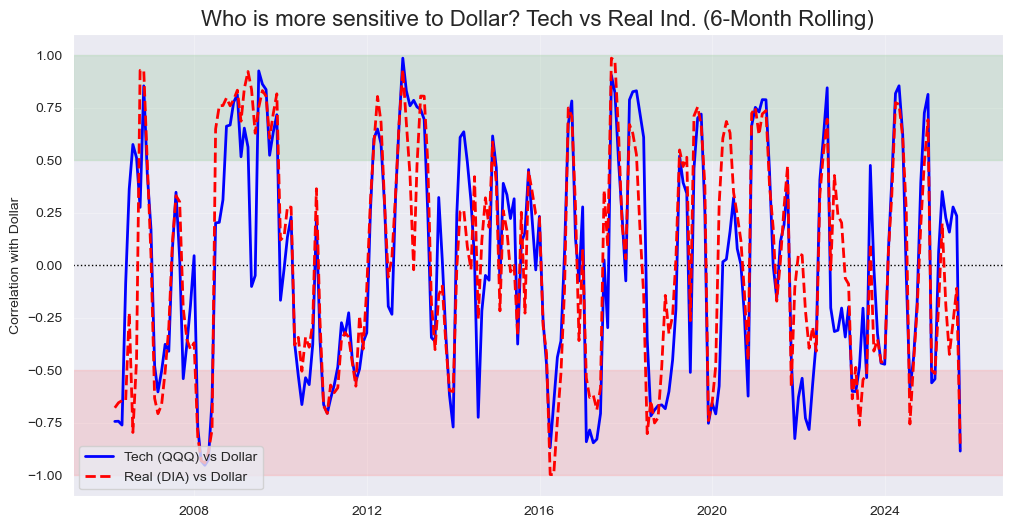

📊 현재 달러 민감도 (최근 6개월):
1. 테크(QQQ): -0.88 (낮을수록 달러에 취약)
2. 제조(DIA): -0.87
👉 결론: 둘 다 똑같이 움직입니다. (거시경제 이슈)


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

# 1. DB 연결
db_uri = "postgresql+psycopg2://xodh3@localhost:5432/economy_db"
engine = create_engine(db_uri)

def get_data(symbol, name):
    # market_price_daily 테이블 사용
    query = f"SELECT trade_date, close_price FROM market_price_daily WHERE symbol = '{symbol}' ORDER BY trade_date ASC"
    conn = engine.raw_connection()
    try:
        df = pd.read_sql(query, conn)
    finally:
        conn.close()
    if df.empty: return pd.DataFrame()

    df = df.rename(columns={'trade_date': 'trade_date', 'close_price': name})
    df['trade_date'] = pd.to_datetime(df['trade_date'], utc=True)
    df = df.set_index('trade_date').resample('M').last()
    return df

print("🏭 테크 vs 제조 데이터 소환 중...", end=" ")

# (1) 주인공들
df_tech = get_data('QQQ', 'Tech (QQQ)')     # 미래 가치
df_real = get_data('DIA', 'Real (DIA)')     # 현물/제조 (다우존스)
df_dollar = get_data('DXY', 'Dollar (DXY)') # 기준

print("완료! ✅")

# 2. 데이터 합치기
df_sector = pd.concat([df_tech, df_real, df_dollar], axis=1).dropna()

# ---------------------------------------------------------
# 🌊 이동 상관관계 (Rolling Correlation) 분석
# ---------------------------------------------------------
# "달러와의 관계가 시간에 따라 어떻게 변했나?"
window_size = 6 # 6개월 추세

# 테크 vs 달러
roll_tech_dxy = df_sector['Tech (QQQ)'].rolling(window=window_size).corr(df_sector['Dollar (DXY)'])
# 제조 vs 달러
roll_real_dxy = df_sector['Real (DIA)'].rolling(window=window_size).corr(df_sector['Dollar (DXY)'])

# 3. 그래프 그리기
plt.figure(figsize=(12, 6))

# 기준선 (0)
plt.axhline(0, color='black', linestyle=':', linewidth=1)

# 테크 (파란색)
plt.plot(roll_tech_dxy.index, roll_tech_dxy,
         label='Tech (QQQ) vs Dollar', color='blue', linewidth=2)

# 제조 (빨간색)
plt.plot(roll_real_dxy.index, roll_real_dxy,
         label='Real (DIA) vs Dollar', color='red', linestyle='--', linewidth=2)

plt.title(f"Who is more sensitive to Dollar? Tech vs Real Ind. ({window_size}-Month Rolling)", fontsize=16)
plt.ylabel("Correlation with Dollar")
plt.legend(loc='lower left')
plt.grid(True, alpha=0.3)

# 4. 부자/빈자 영역 색칠하기
# 상관계수가 -0.5 이하인 구간 (달러 오르면 박살나는 구간)
plt.axhspan(-1, -0.5, color='red', alpha=0.1, label='Danger Zone (Dollar Hurts)')
plt.axhspan(0.5, 1, color='green', alpha=0.1, label='Safe Zone (Dollar Helps)')

plt.show()

# 5. 현재 스코어 확인
print(f"📊 현재 달러 민감도 (최근 {window_size}개월):")
print(f"1. 테크(QQQ): {roll_tech_dxy.iloc[-1]:.2f} (낮을수록 달러에 취약)")
print(f"2. 제조(DIA): {roll_real_dxy.iloc[-1]:.2f}")

diff = roll_tech_dxy.iloc[-1] - roll_real_dxy.iloc[-1]
if abs(diff) < 0.2:
    print("👉 결론: 둘 다 똑같이 움직입니다. (거시경제 이슈)")
elif roll_tech_dxy.iloc[-1] < roll_real_dxy.iloc[-1]:
    print("👉 결론: 님의 가설대로 '테크'가 달러 충격을 더 심하게 받습니다.")
else:
    print("👉 결론: 의외로 '제조업'이 달러 충격을 더 받습니다.")

⏳ 3년 전(2022년) 데이터 복원 중... 완료! ✅


/var/folders/px/mxxc21bs63gcw44m35sp_51r0000gn/T/ipykernel_2881/2295772207.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
/var/folders/px/mxxc21bs63gcw44m35sp_51r0000gn/T/ipykernel_2881/2295772207.py:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.set_index('trade_date').resample('M').last()
/var/folders/px/mxxc21bs63gcw44m35sp_51r0000gn/T/ipykernel_2881/2295772207.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
/var/folders/px/mxxc21bs63gcw44m35sp_51r0000gn/T/ipykernel_2881/2295772207.py:20: FutureWarning: 'M' is deprecated and will be removed

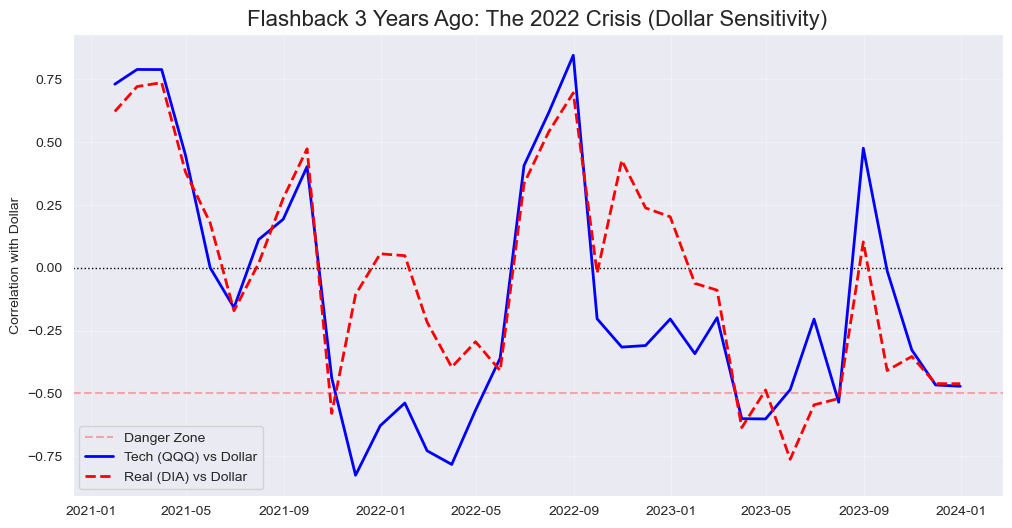

🗓️ 3년 전 (2022년 12월 기준) 성적표:
1. 테크(QQQ): -0.20
2. 제조(DIA): 0.20
👉 발견! 3년 전에는 두 섹터가 '따로' 놀았습니다! (차별화)
   (그때는 테크만 유독 달러한테 두들겨 맞았네요.)


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

# 1. DB 연결 (유지)
db_uri = "postgresql+psycopg2://xodh3@localhost:5432/economy_db"
engine = create_engine(db_uri)

def get_data(symbol, name):
    query = f"SELECT trade_date, close_price FROM market_price_daily WHERE symbol = '{symbol}' ORDER BY trade_date ASC"
    conn = engine.raw_connection()
    try:
        df = pd.read_sql(query, conn)
    finally:
        conn.close()
    if df.empty: return pd.DataFrame()

    df = df.rename(columns={'trade_date': 'trade_date', 'close_price': name})
    df['trade_date'] = pd.to_datetime(df['trade_date'], utc=True)
    df = df.set_index('trade_date').resample('M').last()
    return df

print("⏳ 3년 전(2022년) 데이터 복원 중...", end=" ")

# 데이터 가져오기 (전체 기간)
df_tech = get_data('QQQ', 'Tech (QQQ)')
df_real = get_data('DIA', 'Real (DIA)')
df_dollar = get_data('DXY', 'Dollar (DXY)')

# 합치기
df_all = pd.concat([df_tech, df_real, df_dollar], axis=1).dropna()

print("완료! ✅")

# ---------------------------------------------------------
# 🌊 이동 상관관계 (Rolling Correlation) - 전체 역사 보기
# ---------------------------------------------------------
window_size = 6

# 전체 기간에 대해 계산
roll_tech = df_all['Tech (QQQ)'].rolling(window=window_size).corr(df_all['Dollar (DXY)'])
roll_real = df_all['Real (DIA)'].rolling(window=window_size).corr(df_all['Dollar (DXY)'])

# ---------------------------------------------------------
# 🔍 3년 전 집중 분석 (2022년)
# ---------------------------------------------------------
# 2025년 기준 3년 전 = 2022년 1월 ~ 2022년 12월
target_year = '2022'
subset_tech = roll_tech[target_year]
subset_real = roll_real[target_year]

# 시각화 (2021년 ~ 2023년 구간 확대)
plt.figure(figsize=(12, 6))

# 기준선
plt.axhline(0, color='black', linestyle=':', linewidth=1)
plt.axhline(-0.5, color='red', linestyle='--', alpha=0.3, label='Danger Zone')

# 2021~2023년 데이터만 잘라서 그리기
plot_start = '2021-01-01'
plot_end = '2023-12-31'

plt.plot(roll_tech[plot_start:plot_end].index, roll_tech[plot_start:plot_end],
         label='Tech (QQQ) vs Dollar', color='blue', linewidth=2)

plt.plot(roll_real[plot_start:plot_end].index, roll_real[plot_start:plot_end],
         label='Real (DIA) vs Dollar', color='red', linestyle='--', linewidth=2)

plt.title("Flashback 3 Years Ago: The 2022 Crisis (Dollar Sensitivity)", fontsize=16)
plt.ylabel("Correlation with Dollar")
plt.legend(loc='lower left')
plt.grid(True, alpha=0.3)
plt.show()

# 📊 2022년 말 성적표 (그 당시 상황)
print(f"🗓️ 3년 전 (2022년 12월 기준) 성적표:")
try:
    tech_corr_2022 = subset_tech.iloc[-1]
    real_corr_2022 = subset_real.iloc[-1]

    print(f"1. 테크(QQQ): {tech_corr_2022:.2f}")
    print(f"2. 제조(DIA): {real_corr_2022:.2f}")

    diff = abs(tech_corr_2022 - real_corr_2022)

    if diff > 0.3:
        print("👉 발견! 3년 전에는 두 섹터가 '따로' 놀았습니다! (차별화)")
        if tech_corr_2022 < real_corr_2022:
            print("   (그때는 테크만 유독 달러한테 두들겨 맞았네요.)")
    else:
        print("👉 발견! 3년 전에도 지금처럼 다 같이 죽었습니다. (시스템 위기)")

except:
    print("⚠️ 2022년 데이터가 부족합니다.")

📂 ETF/주식 데이터만 골라내는 중... 완료! (총 25개 ETF 발견) ✅


/var/folders/px/mxxc21bs63gcw44m35sp_51r0000gn/T/ipykernel_2881/745421141.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df_all.resample('M').last()


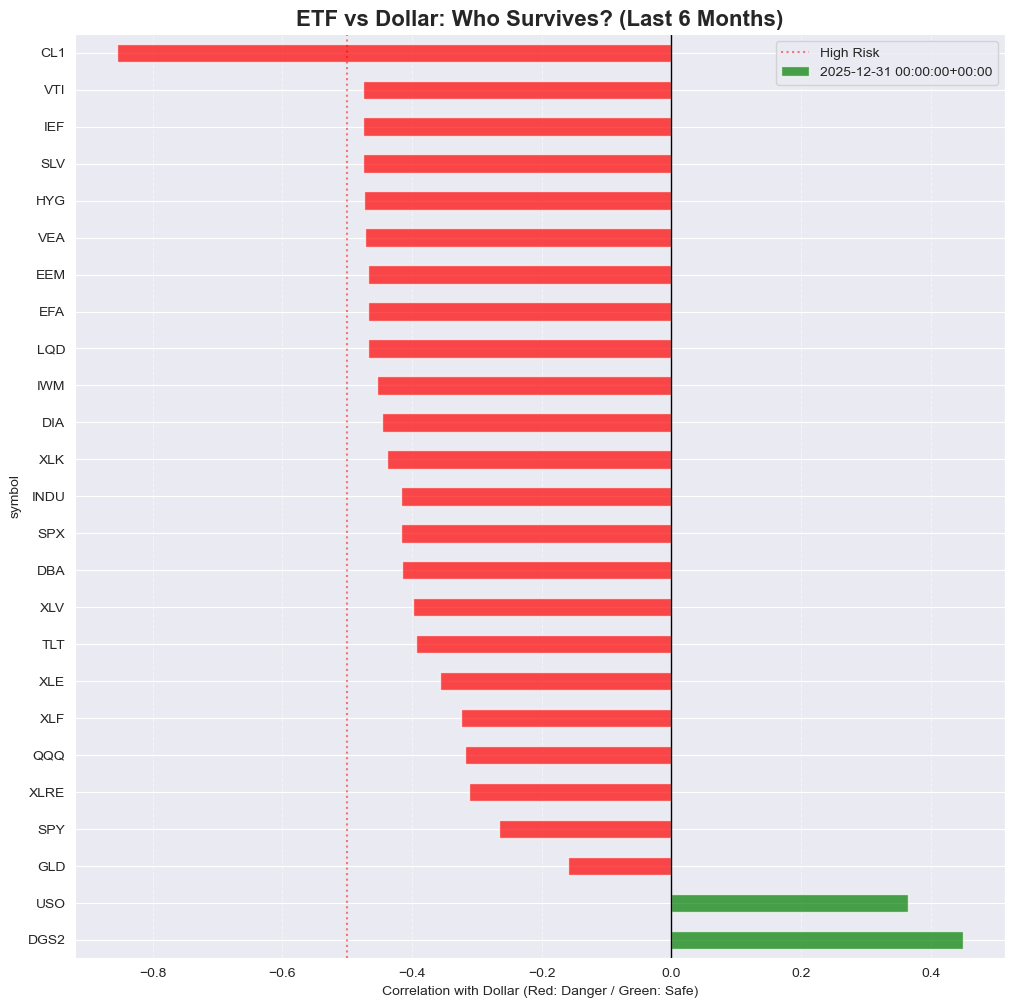

--------------------------------------------------
🛡️ [ETF 방어력 랭킹] 달러가 오를 때 내 계좌의 운명은?
--------------------------------------------------
🟢 [Top Hedges] 달러와 함께 오르는 친구들 (방어자):
symbol
DGS2    0.449237
USO     0.364125
Name: 2025-12-31 00:00:00+00:00, dtype: float64

🔴 [Top Victims] 달러 오르면 박살나는 친구들 (피해자):
symbol
HYG   -0.474416
SLV   -0.475245
IEF   -0.475458
VTI   -0.475725
CL1   -0.854235
Name: 2025-12-31 00:00:00+00:00, dtype: float64


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

# 1. DB 연결
db_uri = "postgresql+psycopg2://xodh3@localhost:5432/economy_db"
engine = create_engine(db_uri)

print("📂 ETF/주식 데이터만 골라내는 중...", end=" ")

# 2. 데이터 가져오기
query = "SELECT trade_date, symbol, close_price FROM market_price_daily ORDER BY trade_date ASC"
with engine.connect() as conn:
    df_raw = pd.read_sql(query, conn)

# 피벗팅
df_all = df_raw.pivot(index='trade_date', columns='symbol', values='close_price')
df_all.index = pd.to_datetime(df_all.index, utc=True)

# 3. 🛠️ 데이터 살려내기 (전처리 강화)
# (1) 주말/공휴일 등으로 빈 곳은 전날 데이터로 채움 (ffill) -> 데이터 탈락 방지
df_all = df_all.ffill()
# (2) 월말 데이터로 변환
df_monthly = df_all.resample('M').last()

# 4. 🧹 환율 걸러내기 (Filtering)
# 달러(DXY)는 기준이니까 남겨두고, 나머지 중에서 "이름이 5글자 이상"인 건 환율로 간주하고 뺍니다.
# (예: USDKRW, EURUSD -> 제외 / QQQ, SPY, GLD, USO -> 포함)
target = 'DXY'
etf_columns = [col for col in df_monthly.columns if (len(col) <= 4 or col == target) and col != 'USGG10YR']

# 만약 4글자 이하인데 환율인게 있다면 여기서 수동으로 빼도 됩니다.
# 여기서는 심플하게 길이로 필터링합니다.
df_etfs = df_monthly[etf_columns]

print(f"완료! (총 {len(df_etfs.columns)-1}개 ETF 발견) ✅")

# 5. 상관관계 분석 (최근 6개월)
if target in df_etfs.columns:
    window_size = 6
    rolling_corrs = df_etfs.rolling(window=window_size).corr(df_etfs[target])

    # 가장 최근 데이터 가져오기
    latest_corrs = rolling_corrs.iloc[-1].dropna().sort_values(ascending=False)

    # 기준(DXY) 제외
    latest_corrs = latest_corrs.drop(target, errors='ignore')

    # ---------------------------------------------------------
    # 📊 시각화: ETF 전용 랭킹
    # ---------------------------------------------------------
    plt.figure(figsize=(12, 12)) # 그래프 길게

    # 색상: 초록(방어) vs 빨강(위험)
    colors = ['green' if x > 0 else 'red' for x in latest_corrs.values]

    latest_corrs.plot(kind='barh', color=colors, alpha=0.7)

    plt.axvline(0, color='black', linewidth=1)
    plt.axvline(-0.5, color='red', linestyle=':', alpha=0.5, label='High Risk')

    plt.title(f"ETF vs Dollar: Who Survives? (Last {window_size} Months)", fontsize=16, fontweight='bold')
    plt.xlabel("Correlation with Dollar (Red: Danger / Green: Safe)")
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.legend()
    plt.show()

    # 📝 리포트
    print("-" * 50)
    print(f"🛡️ [ETF 방어력 랭킹] 달러가 오를 때 내 계좌의 운명은?")
    print("-" * 50)
    print("🟢 [Top Hedges] 달러와 함께 오르는 친구들 (방어자):")
    print(latest_corrs[latest_corrs > 0].head(5))
    print("\n🔴 [Top Victims] 달러 오르면 박살나는 친구들 (피해자):")
    print(latest_corrs.tail(5)) # 하위 5개 출력

else:
    print("❌ DXY 데이터가 없습니다.")